In [43]:
import pandas as pd
df=pd.read_csv(r"C:\Users\ymf\Desktop\pic16bGit\rye_data_project_spring2021\Reddit_dataset\Adulting2016-2021.csv")
df

,Unnamed: 0,author,created_utc,domain,full_link,num_comments,over_18,score,selftext,subreddit,title,num_crossposts
0,0,paradisenoir,1469810090,self.Adulting,https://www.reddit.com/r/Adulting/comments/4v7...,1,False,1,I seriously didn't know where to put this ques...,Adulting,Need help with Updating driver's License,NaN
1,1,emptysometimes,1469550546,youtu.be,https://www.reddit.com/r/Adulting/comments/4up...,0,False,1,NaN,Adulting,Adulting 101,NaN
2,2,PortlandPerson94,1468814980,self.Adulting,https://www.reddit.com/r/Adulting/comments/4td...,1,False,4,"How to do laundry, organize your filing cabine...",Adulting,"in the spirit of the discription of this sub, ...",NaN
3,3,thisisthetyty,1467816249,youtube.com,https://www.reddit.com/r/Adulting/comments/4ri...,0,False,1,NaN,Adulting,New youtube video about symptoms of adulting. ...,NaN
4,4,writer318,1467729176,theodysseyonline.com,https://www.reddit.com/r/Adulting/comments/4rc...,0,False,1,NaN,Adulting,"Why Must We Have To ""Adult""?",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
9397,9397,PortlandPerson94,1468814980,self.Adulting,https://www.reddit.com/r/Adulting/comments/4td...,1,False,4,"How to do laundry, organize your filing cabine...",Adulting,"in the spirit of the discription of this sub, ...",NaN
9398,9398,thisisthetyty,1467816249,youtube.com,https://www.reddit.com/r/Adulting/comments/4ri...,0,False,1,NaN,Adulting,New youtube video about symptoms of adulting. ...,NaN
9399,9399,writer318,1467729176,theodysseyonline.com,https://www.reddit.com/r/Adulting/comments/4rc...,0,False,1,NaN,Adulting,"Why Must We Have To ""Adult""?",NaN
9400,9400,apolloxijedi,1467437994,self.Adulting,https://www.reddit.com/r/Adulting/comments/4qw...,3,False,4,So the short version of the story my fiance an...,Adulting,can't believe I'm 30,NaN


In [44]:
df2=df.dropna(subset=['title'])[['title','selftext']]
df2 #leave it to anaylze later

,title,selftext
0,Need help with Updating driver's License,I seriously didn't know where to put this ques...
1,Adulting 101,NaN
2,"in the spirit of the discription of this sub, ...","How to do laundry, organize your filing cabine..."
3,New youtube video about symptoms of adulting. ...,NaN
4,"Why Must We Have To ""Adult""?",NaN
...,...,...
9397,"in the spirit of the discription of this sub, ...","How to do laundry, organize your filing cabine..."
9398,New youtube video about symptoms of adulting. ...,NaN
9399,"Why Must We Have To ""Adult""?",NaN
9400,can't believe I'm 30,So the short version of the story my fiance an...


In [45]:
job = df2[df2['selftext'].str.contains("full time job")|df['title'].str.contains("full time job")]
job.to_csv('job.csv',index = True)

In [46]:
credit = df2[df2['selftext'].str.contains("credit card")|df['title'].str.contains("credit card")]
credit.to_csv('credit.csv',index = True)

In [47]:
dt = df2[df2['selftext'].str.contains("don't know")|df['title'].str.contains("don't know")]
dt.to_csv('dt.csv',index = True)

In [48]:
#Take interesting columns
df1=df[['selftext','num_comments','score','title']]
#drop those with text=NA
df1=df1.dropna(subset=['selftext'])
#drop meaningless text
df1=df1[(df1.selftext!='[removed]') & (df1.selftext!='[deleted]')].reset_index()
#drop duplicate
duplicate = df1.duplicated()
print('There are', duplicate.sum(), 'duplicated values.')
df1=df1.drop_duplicates()
len(df1)

There are 0 duplicated values.


6518

In [49]:
Markov=df1['selftext']

In [50]:
full_time = df1[df1['selftext'].str.contains("full time job")|df['title'].str.contains("full time job")]
full_time.to_csv('full_time_job.csv',index = True)

<ipython-input-50-7d6e16794c5e>:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [51]:
dont_know = df1[df1['selftext'].str.contains("dont know")|df['title'].str.contains("dont know")]
dont_know.to_csv('dont_know.csv',index = True)

<ipython-input-51-c047d844ecb7>:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [52]:
credit = df1[df1['selftext'].str.contains("credit card")|df['title'].str.contains("credit card")]
credit.to_csv('credit_card.csv',index = True)

<ipython-input-52-5e259662fbe7>:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



### Convert to lowercase

In [53]:
df1['selftext']=df1['selftext'].str.lower()
df1['selftext']

0       i seriously didn't know where to put this ques...
1       how to do laundry, organize your filing cabine...
2       so the short version of the story my fiance an...
3       i am tired of myself and other adults not be o...
4       finally mastering public transportation. i fee...
                              ...                        
6513    like which info do i give them? my policy numb...
6514    i seriously didn't know where to put this ques...
6515    how to do laundry, organize your filing cabine...
6516    so the short version of the story my fiance an...
6517    i am tired of myself and other adults not be o...
Name: selftext, Length: 6518, dtype: object

### Remove emoji

In [54]:
def remove_emoji(text):
    text = text.encode('ascii', 'ignore').decode()
    return text

In [55]:
df1['selftext']=df1['selftext'].apply(lambda x: remove_emoji(x))
df1['selftext'][0]

"i seriously didn't know where to put this question, i hope this is an okay place. \n\na little background: so i'm 22 with a valid driver's license from my home state that still has my parents address on it. i actually moved to the state/town i live in several years ago, but have been a bit of a wanderer and rarely had a permanent address so i just didn't want to deal with the hassle of updating my driver's license.\n\n now it's time to do it and i think i may have trouble proving that i'm a resident of this state, even though i've been here for a few years. currently am living with a friend in the most permanent situation i've been in and probably will be for a while longer. he is the one on the lease and has bills in his name, and we only have like a verbal agreement to pay rent/bills, no contract. i don't have any bills of my own or official mail. my w-2 this year had an old address on it that i'm not associated at all with anymore. i have a pay stub, and could get my friend to writ

### Remove url, punctuation, and special characters

In [56]:
#Using regular expression
import re
def remove_other(x):
    x = re.sub("\$"," ", x) #remove $
    x = re.sub("https*\S+", " ", x) #remove url
    x = re.sub("\'\w+", '', x) #remove i'm,we're,let's after the '
    x = re.sub("[0-9]+", '', x) #remove numbers
    return x

In [57]:
df1['selftext']=df1['selftext'].apply(lambda x: remove_other(x))
df1['selftext'][0]

'i seriously didn know where to put this question, i hope this is an okay place. \n\na little background: so i  with a valid driver license from my home state that still has my parents address on it. i actually moved to the state/town i live in several years ago, but have been a bit of a wanderer and rarely had a permanent address so i just didn want to deal with the hassle of updating my driver license.\n\n now it time to do it and i think i may have trouble proving that i a resident of this state, even though i been here for a few years. currently am living with a friend in the most permanent situation i been in and probably will be for a while longer. he is the one on the lease and has bills in his name, and we only have like a verbal agreement to pay rent/bills, no contract. i don have any bills of my own or official mail. my w- this year had an old address on it that i not associated at all with anymore. i have a pay stub, and could get my friend to write up something that says i 

### Remove stopwords

In [58]:
import nltk
from nltk.corpus import stopwords
#nltk.download("stopwords") #uncomment it when run it for the first time
stop_words = set(stopwords.words("english"))
print(stop_words) #all preloaded stopwords

{"shouldn't", 'above', 'all', 'his', 'myself', 'itself', 'as', 'while', 'both', 'only', "didn't", 'me', 'has', 'is', 'no', 'why', 'were', "you've", 'hadn', 'are', 'doesn', 'again', 'wasn', 'him', 'same', 'was', 'how', 'which', 'any', "doesn't", 'then', 'over', 'with', 'after', 'will', 'doing', 'nor', 'under', 'yours', 'you', 'some', 'mustn', 'but', "it's", 'd', 'such', 'up', 'because', 'wouldn', 'them', 'by', 'it', 'its', 'on', 'being', 'have', 't', 'couldn', 'been', 'than', 'am', 'ourselves', 's', "wasn't", 'ain', 'between', 'their', "weren't", 're', 'against', "that'll", 'few', 'had', 'yourselves', 'mightn', 'in', 'did', 'during', 'from', 'himself', 'my', 'don', "mightn't", "haven't", 'for', 'if', 'these', 'once', 'm', 'ours', 'shan', 'herself', 'this', 'to', "you'd", 'your', 'she', 'about', 'themselves', 'or', 'her', "she's", 'll', "shan't", "you're", 'that', "don't", "couldn't", 'y', 'there', 'most', 'now', 'aren', 'does', 'be', "you'll", 'very', "wouldn't", 'theirs', "should've", 

In [59]:
def remove_stopwords(text):
    text = " ".join([word for word in text.split() if word not in stop_words])
    return text

In [60]:
df1['selftext']=df1['selftext'].apply(lambda x: remove_stopwords(x))
df1['selftext'][0]

'seriously know put question, hope okay place. little background: valid driver license home state still parents address it. actually moved state/town live several years ago, bit wanderer rarely permanent address want deal hassle updating driver license. time think may trouble proving resident state, even though years. currently living friend permanent situation probably longer. one lease bills name, like verbal agreement pay rent/bills, contract. bills official mail. w- year old address associated anymore. pay stub, could get friend write something says pay rent place, go dmv waste time guess wanna know enough consider resident? anyone experience this? website gives list acceptable documents prove residency them/they apply me. thanks!'

In [61]:
spec_chars = ["!",'“','"',"#","%","&","'","(",")",
              "*","+",",","-",".","/",":",";","<",
              "=",">","?","@","[","\\","]","^","_",
              "`","{","|","}","~","–"]
for char in spec_chars:
    df1['selftext'] = df1['selftext'].str.replace(char, ' ')
    df1['selftext'] = df1['selftext'].str.split().str.join(" ")
df1['selftext']

0       seriously know put question hope okay place li...
1       laundry organize filing cabinet maintain finan...
2       short version story fiance living parents put ...
3           tired adults open honest other i e really you
4       finally mastering public transportation feel g...
                              ...                        
6513    like info give them policy number agent phone ...
6514    seriously know put question hope okay place li...
6515    laundry organize filing cabinet maintain finan...
6516    short version story fiance living parents put ...
6517        tired adults open honest other i e really you
Name: selftext, Length: 6518, dtype: object

### Check the resulting text to see whatelse we need to clean

In [62]:
df1['selftext'][4]

'finally mastering public transportation feel grown anyone else use moovit app rocks'

### Example of Lemmatization(change rules to rule)

In [63]:
import nltk
#nltk.download('wordnet') #uncommented for 1st time running
from nltk.stem import WordNetLemmatizer

words=df1['selftext'][4].split()
lemmatizer = WordNetLemmatizer()
for word in words:
    print(word + " ---> " + lemmatizer.lemmatize(word))

finally ---> finally
mastering ---> mastering
public ---> public
transportation ---> transportation
feel ---> feel
grown ---> grown
anyone ---> anyone
else ---> else
use ---> use
moovit ---> moovit
app ---> app
rocks ---> rock


In [64]:
def lemmatize(words):
    lemmatizer = WordNetLemmatizer()
    nwords=[]
    for word in words:
        word=lemmatizer.lemmatize(word)
        nwords.append(word)
    return ' '.join(nwords)

In [65]:
df1['selftext']= df1['selftext'].str.split().apply(lambda x: lemmatize(x))
df1['selftext'][4]

'finally mastering public transportation feel grown anyone else use moovit app rock'

### Split words

In [66]:
from sklearn.feature_extraction.text import CountVectorizer

In [67]:
vec=CountVectorizer()
counts=vec.fit_transform(df1['selftext'])
counts=counts.toarray()
count_df=pd.DataFrame(counts,columns=vec.get_feature_names())
big_df=pd.concat((df1,count_df),axis=1)
big_df.head()

,index,selftext,num_comments,score,title,aa,aaa,aaand,aaargh,aagh,...,zone,zoned,zoning,zoology,zoom,zoopla,zootopia,zumiez,zurich,zwillow
0,0,seriously know put question hope okay place li...,1,1,Need help with Updating driver's License,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,laundry organize filing cabinet maintain finan...,1,4,"in the spirit of the discription of this sub, ...",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,5,short version story fiance living parent put t...,3,4,can't believe I'm 30,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,6,tired adult open honest other i e really you,1,5,Can't we just be open and honest,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8,finally mastering public transportation feel g...,0,2,Public transportation,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [68]:
# List of all words across rows
import itertools
import collections
def count_words(text):
    all_words = list(itertools.chain(*text.str.split()))
    counts = collections.Counter(all_words)
    counts_df = pd.DataFrame(counts.most_common(100),
                            columns=['words', 'count'])

    return counts_df
count_words(df1['selftext'])

,words,count
0,like,4771
1,im,4729
2,get,4608
3,know,3755
4,job,3644
...,...,...
95,keep,754
96,long,744
97,look,734
98,question,714


In [69]:
stop_words.update({'would','k','im','could','also','amp','much','one','like','get','since'})
df1['selftext']=df1['selftext'].apply(lambda x: remove_stopwords(x))
count_df=count_words(df1['selftext'])
count_df.head(30)

,words,count
0,know,3755
1,job,3644
2,time,3598
3,want,3169
4,year,3037
5,work,2828
6,thing,2480
7,need,2455
8,feel,2431
9,really,2331


In [70]:
import plotly.express as px
fig = px.bar(count_df.head(10), x='words', y='count', title="Top 10 words in Adult")
fig.show()

In [71]:
!pip install wordcloud

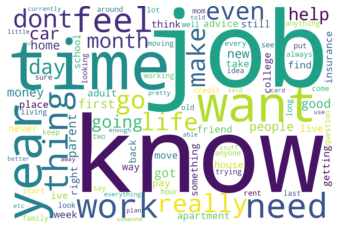

In [72]:
# Libraries

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create a list of word
text=' '.join(count_df.words)

# Create the wordcloud object
wordcloud = WordCloud(width=1500, height=1000, margin=0,background_color='white').generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

### Two grams Frequency

In [73]:
from nltk.util import ngrams
def count_2gram(text):
    all_words = list(itertools.chain(*text.str.split()))
    esBigrams = ngrams(all_words, 2)
    counts = collections.Counter(esBigrams)
    counts_df = pd.DataFrame(counts.most_common(100),
                            columns=['words', 'count'])
    dictionary2 = [' '.join(tup) for tup in counts_df.words]
    counts_df.words=dictionary2

    return counts_df
counts_df2=count_2gram(df1['selftext'])
counts_df2.head(20)

,words,count
0,dont know,547
1,year old,458
2,full time,386
3,credit card,353
4,first time,340
5,dont want,306
6,high school,292
7,time job,231
8,part time,220
9,year ago,205


In [74]:
fig = px.bar(counts_df2.head(10), x='words', y='count', title="Top 10 2-grams in Adult")
fig.show()

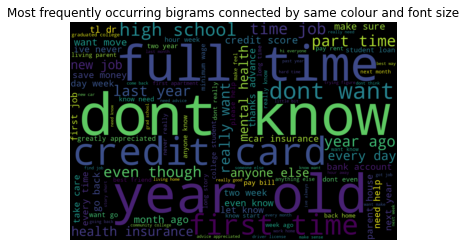

In [75]:
words_dict = dict(counts_df2.values)

wordCloud = WordCloud(max_words=200, height=1000, width=1500)
wordCloud.generate_from_frequencies(words_dict)
plt.title('Most frequently occurring bigrams connected by same colour and font size')
plt.imshow(wordCloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [76]:
from nltk.util import ngrams
def count_3gram(text):
    all_words = list(itertools.chain(*text.str.split()))
    esBigrams = ngrams(all_words, 3)
    counts = collections.Counter(esBigrams)
    counts_df = pd.DataFrame(counts.most_common(100),
                            columns=['words', 'count'])
    dictionary3 = [' '.join(tup) for tup in counts_df.words]
    counts_df.words=dictionary3

    return counts_df
counts_df3=count_3gram(df1['selftext'])
counts_df3.head(20)

,words,count
0,full time job,142
1,part time job,80
2,long story short,70
3,working full time,59
4,work full time,56
5,dont even know,50
6,work part time,35
7,year old female,33
8,advice greatly appreciated,32
9,go back school,30


In [77]:
fig = px.bar(counts_df3.head(10), x='words', y='count', title="Top 10 3-grams in Adult")
fig.show()

In [78]:
from nltk.util import ngrams
def count_4gram(text):
    all_words = list(itertools.chain(*text.str.split()))
    esBigrams = ngrams(all_words, 4)
    counts = collections.Counter(esBigrams)
    counts_df = pd.DataFrame(counts.most_common(100),
                            columns=['words', 'count'])
    dictionary4 = [' '.join(tup) for tup in counts_df.words]
    counts_df.words=dictionary4

    return counts_df
counts_df4=count_4gram(df1['selftext'])
counts_df4.head(20)

,words,count
0,hi hope great day,26
1,hope great day week,26
2,great day week month,26
3,day week month year,26
4,week month year far,26
5,month year far probably,26
6,year far probably trying,26
7,far probably trying hang,26
8,probably trying hang adulting,26
9,trying hang adulting thing,26


In [79]:
fig = px.bar(counts_df4.head(10), x='words', y='count', title="Top 10 4-grams in Adult")
fig.show()

### Try Markov Chain to generate synthetic text

In [80]:
import random
def markov_text(s, n, seed,length):
    '''
    Generates synthetic text according to an n-th order Markov model
    Parameter s: input string of real text
    Parameter n: integer n, the order of the model
    Parameter seed: the initial string that gets the Markov model started.
    Parameter length: integer, the size of the text to generate. default=100
    '''
    counts = count_ngrams(s, n+1)
    fake=seed
    for i in range(length):
        previous = fake[(-n):]
        # filter dict to keep only matching grams
        sub = {}
        for key in counts:
            if key[:-1] == previous: 
                sub[key] = counts[key]
    # convert to lists for use with random.choices
        choices = list(sub.keys())
        weights = [sub[key] for key in choices]
        new_gram = random.choices(choices, weights)[0]
        new_char = new_gram[-1]
        fake+=new_char
    return fake 

In [81]:
def count_ngrams(s,n=1):
    '''
    Counts the number of times each n-gram occurs in a string 's'
    Parameter s: input string
    Parameter n: input integer n to specify 'n-gram' that need to be count
    '''
    D={}
    #loop through s, untill there are not enough characters left forming n-gram
    for i in range(len(s)-(n-1)): 
        D[s[i:i+n]]=0 # initialize values to avoid key errors
    for i in range(len(s)-(n-1)):
        D[s[i:i+n]]+=1 #the value of each n-gram is their counts in s
    return D
    
#test the output
count_ngrams("tortoise", n = 2)

{'to': 2, 'or': 1, 'rt': 1, 'oi': 1, 'is': 1, 'se': 1}

In [82]:
import itertools
all_words = list(itertools.chain(*Markov.str.split()))
s=' '.join(all_words)

In [83]:
markov_text(s, n = 9, length = 400, seed = "full time")

'full time job paid first time home owner insurance friend friend flossing seems stick anyone want atone make decision ill regret lot till day row day eat mini cupcake ice cream breakfast sweet sticky situation experience public except wiser mature saying looking another cousin talked recently divorced daughter always work pm usually pay people move leaving behind quit leaving message linkedin use professio'